In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

# select which rgis to analyze
if validation_only:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# get list of rgis to analyze
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(os.path.join(folder_save, "Average AAs")) if i[-3:]=='tif' ] ))

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

3002


In [10]:
# open the list of the final ELA calculated for each average product
path_open = os.path.join(folder_save, 'Average AAs', 'final_glacier_stats.csv')
df_all_ela = pd.read_csv(path_open).sort_values('total_area')
df_all_ela.head()

,RGIId,ela,aar,off_glacier,total_area,total_observed,total_snow
516,RGI60-01.11971,1740,0.7507,0,0.3711,0.3301,0.2478
20,RGI60-01.08366,890,0.0000,1,1.9676,1.9676,0.0000
26,RGI60-01.12245,1400,0.0047,1,1.9828,1.9828,0.0094
29,RGI60-01.21347,1090,0.0067,1,1.9933,1.6016,0.0108
1,RGI60-01.11632,1710,0.0418,1,1.9976,1.8208,0.0761


In [62]:
# for each glacier, open the average product, infill missing data, resave
i=0
for idx,row in df_all_ela.iterrows():
    i+=1
    
    # get rgiid
    rgiid = row['RGIId']
    
#     if rgiid!="RGI60-01.00570": continue
#     row_save = row.copy() 
    
    # grab just this rgi geometry and info
    rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
    single_geometry = rgi_single.geometry
    ga = rgi_single['Area'].values
    
    print(f"Starting {i} of {len(df_all_ela)}: {rgiid}  {ga} km2")
    
    # get ela that was found
    ela = row['ela']
    
    # open glacier products
    path_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final.tif")
    snow = riox.open_rasterio(path_avg)
#     glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    xr_dem = snowFun.get_year_DEM(single_geometry, 2020, smoothed=0) 
    
    # make sure dimensions match up
    xr_dem = xr_dem.reindex_like(snow, method='nearest')
    
    # infill by making pixels at or above ela snow, below ela ice
    snow_infill = xr.where(xr_dem<ela, 1, 2)
    snow_infill = snow.where(snow<3, snow_infill).squeeze()
    
    # or infill using nearest observation
#     snow_infill = snow.where(snow.isin([1,2]), np.nan)
#     snow_infill = snow_infill.interpolate_na(dim=['x','y'],method='nearest', use_coordinate=False)
#     snow_infill = snow_infill.where(snow>0,0).atype('uint8')
    
    # save
    out_path = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final_infill.tif")
    snow_infill.rio.to_raster(raster_path=out_path, compress='DEFLATE')

print('Done!')
    

Starting 1 of 3002: RGI60-01.11971  [2.428] km2
Starting 2 of 3002: RGI60-01.08366  [2.016] km2
Starting 3 of 3002: RGI60-01.12245  [2.021] km2
Starting 4 of 3002: RGI60-01.21347  [2.024] km2
Starting 5 of 3002: RGI60-01.11632  [2.] km2
Starting 6 of 3002: RGI60-01.03614  [2.004] km2
Starting 7 of 3002: RGI60-01.02453  [2.006] km2
Starting 8 of 3002: RGI60-01.20889  [2.] km2
Starting 9 of 3002: RGI60-01.08203  [2.002] km2
Starting 10 of 3002: RGI60-01.11595  [2.003] km2
Starting 11 of 3002: RGI60-01.09047  [2.004] km2
Starting 12 of 3002: RGI60-01.05672  [2.046] km2
Starting 13 of 3002: RGI60-01.25183  [2.002] km2
Starting 14 of 3002: RGI60-01.00564  [2.015] km2
Starting 15 of 3002: RGI60-01.05487  [2.004] km2
Starting 16 of 3002: RGI60-01.17509  [2.005] km2
Starting 17 of 3002: RGI60-01.10867  [2.005] km2
Starting 18 of 3002: RGI60-01.12977  [2.006] km2
Starting 19 of 3002: RGI60-01.08199  [2.006] km2
Starting 20 of 3002: RGI60-01.19457  [2.007] km2
Starting 21 of 3002: RGI60-01.03088

Starting 168 of 3002: RGI60-01.03027  [2.121] km2
Starting 169 of 3002: RGI60-01.16650  [2.122] km2
Starting 170 of 3002: RGI60-01.07101  [2.123] km2
Starting 171 of 3002: RGI60-01.18978  [2.123] km2
Starting 172 of 3002: RGI60-01.03179  [2.132] km2
Starting 173 of 3002: RGI60-01.12496  [2.126] km2
Starting 174 of 3002: RGI60-01.17519  [2.128] km2
Starting 175 of 3002: RGI60-01.19963  [2.127] km2
Starting 176 of 3002: RGI60-01.15543  [2.128] km2
Starting 177 of 3002: RGI60-01.13830  [2.13] km2
Starting 178 of 3002: RGI60-01.00559  [2.13] km2
Starting 179 of 3002: RGI60-01.02945  [2.13] km2
Starting 180 of 3002: RGI60-01.00077  [2.13] km2
Starting 181 of 3002: RGI60-01.20866  [2.133] km2
Starting 182 of 3002: RGI60-01.10856  [2.133] km2
Starting 183 of 3002: RGI60-01.05455  [2.135] km2
Starting 184 of 3002: RGI60-01.23669  [2.142] km2
Starting 185 of 3002: RGI60-01.00670  [2.134] km2
Starting 186 of 3002: RGI60-01.06230  [2.138] km2
Starting 187 of 3002: RGI60-01.09107  [2.137] km2
Star

Starting 333 of 3002: RGI60-01.23195  [2.255] km2
Starting 334 of 3002: RGI60-01.23266  [2.256] km2
Starting 335 of 3002: RGI60-01.18043  [2.256] km2
Starting 336 of 3002: RGI60-01.07094  [2.257] km2
Starting 337 of 3002: RGI60-01.22633  [2.26] km2
Starting 338 of 3002: RGI60-01.03204  [2.267] km2
Starting 339 of 3002: RGI60-01.05541  [2.261] km2
Starting 340 of 3002: RGI60-01.20334  [2.259] km2
Starting 341 of 3002: RGI60-01.03148  [2.262] km2
Starting 342 of 3002: RGI60-01.17424  [2.272] km2
Starting 343 of 3002: RGI60-01.17769  [2.267] km2
Starting 344 of 3002: RGI60-01.05959  [2.268] km2
Starting 345 of 3002: RGI60-01.05161  [2.274] km2
Starting 346 of 3002: RGI60-01.05339  [2.273] km2
Starting 347 of 3002: RGI60-01.08455  [2.273] km2
Starting 348 of 3002: RGI60-01.13177  [2.274] km2
Starting 349 of 3002: RGI60-01.07046  [2.276] km2
Starting 350 of 3002: RGI60-01.01278  [2.275] km2
Starting 351 of 3002: RGI60-01.13917  [2.28] km2
Starting 352 of 3002: RGI60-01.21276  [2.275] km2
St

Starting 499 of 3002: RGI60-01.18167  [2.407] km2
Starting 500 of 3002: RGI60-01.20268  [2.41] km2
Starting 501 of 3002: RGI60-01.25130  [2.412] km2
Starting 502 of 3002: RGI60-01.17720  [2.409] km2
Starting 503 of 3002: RGI60-01.04280  [2.41] km2
Starting 504 of 3002: RGI60-01.04481  [2.414] km2
Starting 505 of 3002: RGI60-01.23062  [2.413] km2
Starting 506 of 3002: RGI60-01.23890  [2.412] km2
Starting 507 of 3002: RGI60-01.14194  [2.414] km2
Starting 508 of 3002: RGI60-01.19337  [2.418] km2
Starting 509 of 3002: RGI60-01.06816  [2.446] km2
Starting 510 of 3002: RGI60-01.01681  [2.417] km2
Starting 511 of 3002: RGI60-01.02452  [2.418] km2
Starting 512 of 3002: RGI60-01.19161  [2.419] km2
Starting 513 of 3002: RGI60-01.19053  [2.436] km2
Starting 514 of 3002: RGI60-01.08064  [2.431] km2
Starting 515 of 3002: RGI60-01.18679  [2.419] km2
Starting 516 of 3002: RGI60-01.13292  [2.425] km2
Starting 517 of 3002: RGI60-01.11573  [2.424] km2
Starting 518 of 3002: RGI60-01.19487  [2.429] km2
St

Starting 664 of 3002: RGI60-01.09557  [2.594] km2
Starting 665 of 3002: RGI60-01.09209  [2.597] km2
Starting 666 of 3002: RGI60-01.20662  [2.597] km2
Starting 667 of 3002: RGI60-01.04583  [2.6] km2
Starting 668 of 3002: RGI60-01.23388  [2.603] km2
Starting 669 of 3002: RGI60-01.02544  [2.607] km2
Starting 670 of 3002: RGI60-01.05413  [2.603] km2
Starting 671 of 3002: RGI60-01.00426  [2.606] km2
Starting 672 of 3002: RGI60-01.22834  [2.606] km2
Starting 673 of 3002: RGI60-01.08911  [2.608] km2
Starting 674 of 3002: RGI60-01.04651  [2.619] km2
Starting 675 of 3002: RGI60-01.19995  [2.608] km2
Starting 676 of 3002: RGI60-01.15566  [2.61] km2
Starting 677 of 3002: RGI60-01.05779  [2.614] km2
Starting 678 of 3002: RGI60-01.11534  [2.608] km2
Starting 679 of 3002: RGI60-01.04860  [2.615] km2
Starting 680 of 3002: RGI60-01.04919  [2.616] km2
Starting 681 of 3002: RGI60-01.26315  [2.63] km2
Starting 682 of 3002: RGI60-01.18177  [2.615] km2
Starting 683 of 3002: RGI60-01.17767  [2.628] km2
Star

Starting 829 of 3002: RGI60-01.18316  [2.811] km2
Starting 830 of 3002: RGI60-01.01573  [2.809] km2
Starting 831 of 3002: RGI60-01.02607  [2.808] km2
Starting 832 of 3002: RGI60-01.19388  [2.812] km2
Starting 833 of 3002: RGI60-01.03395  [2.811] km2
Starting 834 of 3002: RGI60-01.04653  [2.811] km2
Starting 835 of 3002: RGI60-01.19598  [2.814] km2
Starting 836 of 3002: RGI60-01.20515  [2.817] km2
Starting 837 of 3002: RGI60-01.19348  [2.815] km2
Starting 838 of 3002: RGI60-01.05824  [2.818] km2
Starting 839 of 3002: RGI60-01.03136  [2.82] km2
Starting 840 of 3002: RGI60-01.06323  [2.828] km2
Starting 841 of 3002: RGI60-01.04256  [2.82] km2
Starting 842 of 3002: RGI60-01.05630  [2.821] km2
Starting 843 of 3002: RGI60-01.08276  [2.823] km2
Starting 844 of 3002: RGI60-01.22497  [2.839] km2
Starting 845 of 3002: RGI60-01.26389  [2.826] km2
Starting 846 of 3002: RGI60-01.04554  [2.827] km2
Starting 847 of 3002: RGI60-01.24849  [2.83] km2
Starting 848 of 3002: RGI60-01.15767  [2.834] km2
Sta

Starting 994 of 3002: RGI60-01.09421  [3.054] km2
Starting 995 of 3002: RGI60-01.19462  [3.056] km2
Starting 996 of 3002: RGI60-01.05097  [3.059] km2
Starting 997 of 3002: RGI60-01.05970  [3.061] km2
Starting 998 of 3002: RGI60-01.23053  [3.063] km2
Starting 999 of 3002: RGI60-01.08323  [3.062] km2
Starting 1000 of 3002: RGI60-01.20753  [3.072] km2
Starting 1001 of 3002: RGI60-01.07545  [3.078] km2
Starting 1002 of 3002: RGI60-01.05142  [3.065] km2
Starting 1003 of 3002: RGI60-01.02605  [3.066] km2
Starting 1004 of 3002: RGI60-01.08400  [3.073] km2
Starting 1005 of 3002: RGI60-01.14129  [3.074] km2
Starting 1006 of 3002: RGI60-01.07360  [3.069] km2
Starting 1007 of 3002: RGI60-01.03399  [3.12] km2
Starting 1008 of 3002: RGI60-01.15703  [3.087] km2
Starting 1009 of 3002: RGI60-01.14491  [3.094] km2
Starting 1010 of 3002: RGI60-01.00903  [3.127] km2
Starting 1011 of 3002: RGI60-01.05656  [3.092] km2
Starting 1012 of 3002: RGI60-01.08435  [3.104] km2
Starting 1013 of 3002: RGI60-01.20606 

Starting 1156 of 3002: RGI60-01.16129  [3.36] km2
Starting 1157 of 3002: RGI60-01.01516  [3.361] km2
Starting 1158 of 3002: RGI60-01.04758  [3.359] km2
Starting 1159 of 3002: RGI60-01.05710  [3.37] km2
Starting 1160 of 3002: RGI60-01.22279  [3.383] km2
Starting 1161 of 3002: RGI60-01.20179  [3.37] km2
Starting 1162 of 3002: RGI60-01.03778  [3.375] km2
Starting 1163 of 3002: RGI60-01.11503  [3.381] km2
Starting 1164 of 3002: RGI60-01.20447  [3.382] km2
Starting 1165 of 3002: RGI60-01.24660  [3.382] km2
Starting 1166 of 3002: RGI60-01.19495  [3.383] km2
Starting 1167 of 3002: RGI60-01.15360  [3.381] km2
Starting 1168 of 3002: RGI60-01.08418  [3.383] km2
Starting 1169 of 3002: RGI60-01.23846  [3.392] km2
Starting 1170 of 3002: RGI60-01.20785  [3.39] km2
Starting 1171 of 3002: RGI60-01.21773  [3.392] km2
Starting 1172 of 3002: RGI60-01.07263  [3.395] km2
Starting 1173 of 3002: RGI60-01.01706  [3.408] km2
Starting 1174 of 3002: RGI60-01.05313  [3.415] km2
Starting 1175 of 3002: RGI60-01.037

Starting 1317 of 3002: RGI60-01.02787  [3.698] km2
Starting 1318 of 3002: RGI60-01.23524  [3.712] km2
Starting 1319 of 3002: RGI60-01.19400  [3.706] km2
Starting 1320 of 3002: RGI60-01.23530  [3.705] km2
Starting 1321 of 3002: RGI60-01.13468  [3.721] km2
Starting 1322 of 3002: RGI60-01.04555  [3.71] km2
Starting 1323 of 3002: RGI60-01.17798  [3.719] km2
Starting 1324 of 3002: RGI60-01.15334  [3.757] km2
Starting 1325 of 3002: RGI60-01.20814  [3.728] km2
Starting 1326 of 3002: RGI60-01.01708  [3.731] km2
Starting 1327 of 3002: RGI60-01.22232  [3.729] km2
Starting 1328 of 3002: RGI60-01.08198  [3.737] km2
Starting 1329 of 3002: RGI60-01.22276  [3.738] km2
Starting 1330 of 3002: RGI60-01.25626  [3.739] km2
Starting 1331 of 3002: RGI60-01.17521  [3.739] km2
Starting 1332 of 3002: RGI60-01.16424  [3.743] km2
Starting 1333 of 3002: RGI60-01.03809  [3.751] km2
Starting 1334 of 3002: RGI60-01.00017  [3.765] km2
Starting 1335 of 3002: RGI60-01.12232  [3.754] km2
Starting 1336 of 3002: RGI60-01.

Starting 1479 of 3002: RGI60-01.00982  [4.134] km2
Starting 1480 of 3002: RGI60-01.25141  [4.135] km2
Starting 1481 of 3002: RGI60-01.02702  [4.133] km2
Starting 1482 of 3002: RGI60-01.14057  [4.135] km2
Starting 1483 of 3002: RGI60-01.10930  [4.148] km2
Starting 1484 of 3002: RGI60-01.22225  [4.142] km2
Starting 1485 of 3002: RGI60-01.05419  [4.142] km2
Starting 1486 of 3002: RGI60-01.16250  [4.143] km2
Starting 1487 of 3002: RGI60-01.15480  [4.143] km2
Starting 1488 of 3002: RGI60-01.05164  [4.143] km2
Starting 1489 of 3002: RGI60-01.08119  [4.156] km2
Starting 1490 of 3002: RGI60-01.11607  [4.153] km2
Starting 1491 of 3002: RGI60-01.15960  [4.152] km2
Starting 1492 of 3002: RGI60-01.00425  [4.162] km2
Starting 1493 of 3002: RGI60-01.09978  [4.165] km2
Starting 1494 of 3002: RGI60-01.21732  [4.205] km2
Starting 1495 of 3002: RGI60-01.03745  [4.174] km2
Starting 1496 of 3002: RGI60-01.20874  [4.177] km2
Starting 1497 of 3002: RGI60-01.10182  [4.177] km2
Starting 1498 of 3002: RGI60-01

Starting 1640 of 3002: RGI60-01.11876  [4.627] km2
Starting 1641 of 3002: RGI60-01.08666  [4.629] km2
Starting 1642 of 3002: RGI60-01.17830  [4.633] km2
Starting 1643 of 3002: RGI60-01.11810  [4.65] km2
Starting 1644 of 3002: RGI60-01.17374  [4.66] km2
Starting 1645 of 3002: RGI60-01.14606  [4.662] km2
Starting 1646 of 3002: RGI60-01.20621  [4.659] km2
Starting 1647 of 3002: RGI60-01.08247  [4.66] km2
Starting 1648 of 3002: RGI60-01.24477  [4.666] km2
Starting 1649 of 3002: RGI60-01.01512  [4.665] km2
Starting 1650 of 3002: RGI60-01.09744  [4.67] km2
Starting 1651 of 3002: RGI60-01.20752  [4.69] km2
Starting 1652 of 3002: RGI60-01.16838  [4.686] km2
Starting 1653 of 3002: RGI60-01.20323  [4.678] km2
Starting 1654 of 3002: RGI60-01.21305  [4.682] km2
Starting 1655 of 3002: RGI60-01.11473  [4.689] km2
Starting 1656 of 3002: RGI60-01.12233  [4.686] km2
Starting 1657 of 3002: RGI60-01.22434  [4.695] km2
Starting 1658 of 3002: RGI60-01.16128  [4.696] km2
Starting 1659 of 3002: RGI60-01.0736

Starting 1802 of 3002: RGI60-01.03151  [5.388] km2
Starting 1803 of 3002: RGI60-01.11474  [5.63] km2
Starting 1804 of 3002: RGI60-01.22479  [5.399] km2
Starting 1805 of 3002: RGI60-01.17818  [5.463] km2
Starting 1806 of 3002: RGI60-01.17838  [5.396] km2
Starting 1807 of 3002: RGI60-01.03104  [5.403] km2
Starting 1808 of 3002: RGI60-01.04463  [5.411] km2
Starting 1809 of 3002: RGI60-01.13981  [5.413] km2
Starting 1810 of 3002: RGI60-01.04330  [5.416] km2
Starting 1811 of 3002: RGI60-01.03406  [5.422] km2
Starting 1812 of 3002: RGI60-01.23299  [5.427] km2
Starting 1813 of 3002: RGI60-01.05333  [5.421] km2
Starting 1814 of 3002: RGI60-01.21770  [5.423] km2
Starting 1815 of 3002: RGI60-01.17375  [5.434] km2
Starting 1816 of 3002: RGI60-01.00080  [5.433] km2
Starting 1817 of 3002: RGI60-01.12854  [5.442] km2
Starting 1818 of 3002: RGI60-01.20897  [5.445] km2
Starting 1819 of 3002: RGI60-01.04641  [5.465] km2
Starting 1820 of 3002: RGI60-01.10613  [5.46] km2
Starting 1821 of 3002: RGI60-01.0

Starting 1964 of 3002: RGI60-01.02328  [6.477] km2
Starting 1965 of 3002: RGI60-01.19494  [6.479] km2
Starting 1966 of 3002: RGI60-01.04457  [6.478] km2
Starting 1967 of 3002: RGI60-01.23219  [6.5] km2
Starting 1968 of 3002: RGI60-01.15684  [6.5] km2
Starting 1969 of 3002: RGI60-01.23094  [6.501] km2
Starting 1970 of 3002: RGI60-01.12535  [6.532] km2
Starting 1971 of 3002: RGI60-01.22197  [6.526] km2
Starting 1972 of 3002: RGI60-01.18051  [6.525] km2
Starting 1973 of 3002: RGI60-01.19713  [6.528] km2
Starting 1974 of 3002: RGI60-01.22010  [6.539] km2
Starting 1975 of 3002: RGI60-01.05561  [6.544] km2
Starting 1976 of 3002: RGI60-01.09538  [6.554] km2
Starting 1977 of 3002: RGI60-01.02885  [6.567] km2
Starting 1978 of 3002: RGI60-01.16481  [6.567] km2
Starting 1979 of 3002: RGI60-01.19429  [6.581] km2
Starting 1980 of 3002: RGI60-01.17919  [6.594] km2
Starting 1981 of 3002: RGI60-01.24677  [6.605] km2
Starting 1982 of 3002: RGI60-01.15840  [6.596] km2
Starting 1983 of 3002: RGI60-01.084

Starting 2126 of 3002: RGI60-01.20718  [8.003] km2
Starting 2127 of 3002: RGI60-01.06769  [8.015] km2
Starting 2128 of 3002: RGI60-01.09373  [8.023] km2
Starting 2129 of 3002: RGI60-01.20302  [8.028] km2
Starting 2130 of 3002: RGI60-01.08301  [8.04] km2
Starting 2131 of 3002: RGI60-01.14589  [8.06] km2
Starting 2132 of 3002: RGI60-01.14779  [8.061] km2
Starting 2133 of 3002: RGI60-01.01835  [8.09] km2
Starting 2134 of 3002: RGI60-01.00596  [8.076] km2
Starting 2135 of 3002: RGI60-01.23532  [8.073] km2
Starting 2136 of 3002: RGI60-01.15693  [8.102] km2
Starting 2137 of 3002: RGI60-01.00039  [8.106] km2
Starting 2138 of 3002: RGI60-01.03022  [8.124] km2
Starting 2139 of 3002: RGI60-01.04950  [8.14] km2
Starting 2140 of 3002: RGI60-01.10764  [8.185] km2
Starting 2141 of 3002: RGI60-01.16440  [8.196] km2
Starting 2142 of 3002: RGI60-01.19031  [8.272] km2
Starting 2143 of 3002: RGI60-01.21758  [8.284] km2
Starting 2144 of 3002: RGI60-01.20931  [8.309] km2
Starting 2145 of 3002: RGI60-01.149

Starting 2287 of 3002: RGI60-01.14170  [10.98] km2
Starting 2288 of 3002: RGI60-01.17987  [11.032] km2
Starting 2289 of 3002: RGI60-01.12186  [11.05] km2
Starting 2290 of 3002: RGI60-01.09534  [11.108] km2
Starting 2291 of 3002: RGI60-01.16425  [11.106] km2
Starting 2292 of 3002: RGI60-01.08246  [11.147] km2
Starting 2293 of 3002: RGI60-01.03571  [11.173] km2
Starting 2294 of 3002: RGI60-01.15446  [11.188] km2
Starting 2295 of 3002: RGI60-01.01271  [11.188] km2
Starting 2296 of 3002: RGI60-01.14238  [11.199] km2
Starting 2297 of 3002: RGI60-01.15981  [11.203] km2
Starting 2298 of 3002: RGI60-01.08413  [11.208] km2
Starting 2299 of 3002: RGI60-01.17917  [11.242] km2
Starting 2300 of 3002: RGI60-01.16793  [11.27] km2
Starting 2301 of 3002: RGI60-01.11654  [11.298] km2
Starting 2302 of 3002: RGI60-01.16339  [11.375] km2
Starting 2303 of 3002: RGI60-01.01320  [11.39] km2
Starting 2304 of 3002: RGI60-01.18146  [11.403] km2
Starting 2305 of 3002: RGI60-01.04815  [11.41] km2
Starting 2306 of 

Starting 2445 of 3002: RGI60-01.03795  [15.761] km2
Starting 2446 of 3002: RGI60-01.22188  [15.835] km2
Starting 2447 of 3002: RGI60-01.20196  [15.89] km2
Starting 2448 of 3002: RGI60-01.06003  [15.913] km2
Starting 2449 of 3002: RGI60-01.03540  [15.914] km2
Starting 2450 of 3002: RGI60-01.03523  [16.025] km2
Starting 2451 of 3002: RGI60-01.04531  [16.038] km2
Starting 2452 of 3002: RGI60-01.19778  [16.052] km2
Starting 2453 of 3002: RGI60-01.19921  [16.053] km2
Starting 2454 of 3002: RGI60-01.12734  [16.098] km2
Starting 2455 of 3002: RGI60-01.09431  [16.143] km2
Starting 2456 of 3002: RGI60-01.01270  [16.163] km2
Starting 2457 of 3002: RGI60-01.15149  [16.241] km2
Starting 2458 of 3002: RGI60-01.09240  [16.25] km2
Starting 2459 of 3002: RGI60-01.10188  [16.276] km2
Starting 2460 of 3002: RGI60-01.20997  [16.269] km2
Starting 2461 of 3002: RGI60-01.00584  [16.3] km2
Starting 2462 of 3002: RGI60-01.16748  [16.31] km2
Starting 2463 of 3002: RGI60-01.20859  [16.346] km2
Starting 2464 of 

Starting 2604 of 3002: RGI60-01.12227  [25.867] km2
Starting 2605 of 3002: RGI60-01.05863  [25.694] km2
Starting 2606 of 3002: RGI60-01.15436  [25.705] km2
Starting 2607 of 3002: RGI60-01.09519  [25.736] km2
Starting 2608 of 3002: RGI60-01.20822  [25.809] km2
Starting 2609 of 3002: RGI60-01.09581  [25.839] km2
Starting 2610 of 3002: RGI60-01.04542  [25.995] km2
Starting 2611 of 3002: RGI60-01.14876  [26.094] km2
Starting 2612 of 3002: RGI60-01.01242  [26.094] km2
Starting 2613 of 3002: RGI60-01.03881  [26.224] km2
Starting 2614 of 3002: RGI60-01.20795  [26.281] km2
Starting 2615 of 3002: RGI60-01.14529  [26.336] km2
Starting 2616 of 3002: RGI60-01.01753  [26.388] km2
Starting 2617 of 3002: RGI60-01.22177  [26.476] km2
Starting 2618 of 3002: RGI60-01.16516  [26.489] km2
Starting 2619 of 3002: RGI60-01.11148  [26.502] km2
Starting 2620 of 3002: RGI60-01.23672  [26.582] km2
Starting 2621 of 3002: RGI60-01.05639  [26.556] km2
Starting 2622 of 3002: RGI60-01.26720  [26.564] km2
Starting 262

Starting 2762 of 3002: RGI60-01.12306  [51.458] km2
Starting 2763 of 3002: RGI60-01.19294  [51.725] km2
Starting 2764 of 3002: RGI60-01.19413  [51.692] km2
Starting 2765 of 3002: RGI60-01.00044  [52.215] km2
Starting 2766 of 3002: RGI60-01.09783  [52.602] km2
Starting 2767 of 3002: RGI60-01.23663  [53.133] km2
Starting 2768 of 3002: RGI60-01.25579  [53.238] km2
Starting 2769 of 3002: RGI60-01.15535  [53.442] km2
Starting 2770 of 3002: RGI60-01.15548  [53.499] km2
Starting 2771 of 3002: RGI60-01.26729  [53.616] km2
Starting 2772 of 3002: RGI60-01.00561  [53.795] km2
Starting 2773 of 3002: RGI60-01.21016  [54.523] km2
Starting 2774 of 3002: RGI60-01.09757  [54.752] km2
Starting 2775 of 3002: RGI60-01.17316  [54.668] km2
Starting 2776 of 3002: RGI60-01.03451  [55.317] km2
Starting 2777 of 3002: RGI60-01.14523  [55.677] km2
Starting 2778 of 3002: RGI60-01.21055  [55.698] km2
Starting 2779 of 3002: RGI60-01.17915  [55.97] km2
Starting 2780 of 3002: RGI60-01.09518  [56.093] km2
Starting 2781

Starting 2919 of 3002: RGI60-01.19814  [173.212] km2
Starting 2920 of 3002: RGI60-01.26743  [176.235] km2
Starting 2921 of 3002: RGI60-01.21008  [176.435] km2
Starting 2922 of 3002: RGI60-01.14391  [176.999] km2
Starting 2923 of 3002: RGI60-01.13826  [178.164] km2
Starting 2924 of 3002: RGI60-01.23642  [178.632] km2
Starting 2925 of 3002: RGI60-01.23655  [182.55] km2
Starting 2926 of 3002: RGI60-01.26732  [181.753] km2
Starting 2927 of 3002: RGI60-01.01796  [189.244] km2
Starting 2928 of 3002: RGI60-01.01520  [192.91] km2
Starting 2929 of 3002: RGI60-01.00046  [193.423] km2
Starting 2930 of 3002: RGI60-01.12683  [193.667] km2
Starting 2931 of 3002: RGI60-01.17803  [198.091] km2
Starting 2932 of 3002: RGI60-01.22221  [195.803] km2
Starting 2933 of 3002: RGI60-01.03890  [196.525] km2
Starting 2934 of 3002: RGI60-01.13838  [200.394] km2
Starting 2935 of 3002: RGI60-01.22186  [204.342] km2
Starting 2936 of 3002: RGI60-01.13790  [206.951] km2
Starting 2937 of 3002: RGI60-01.00013  [209.63] 

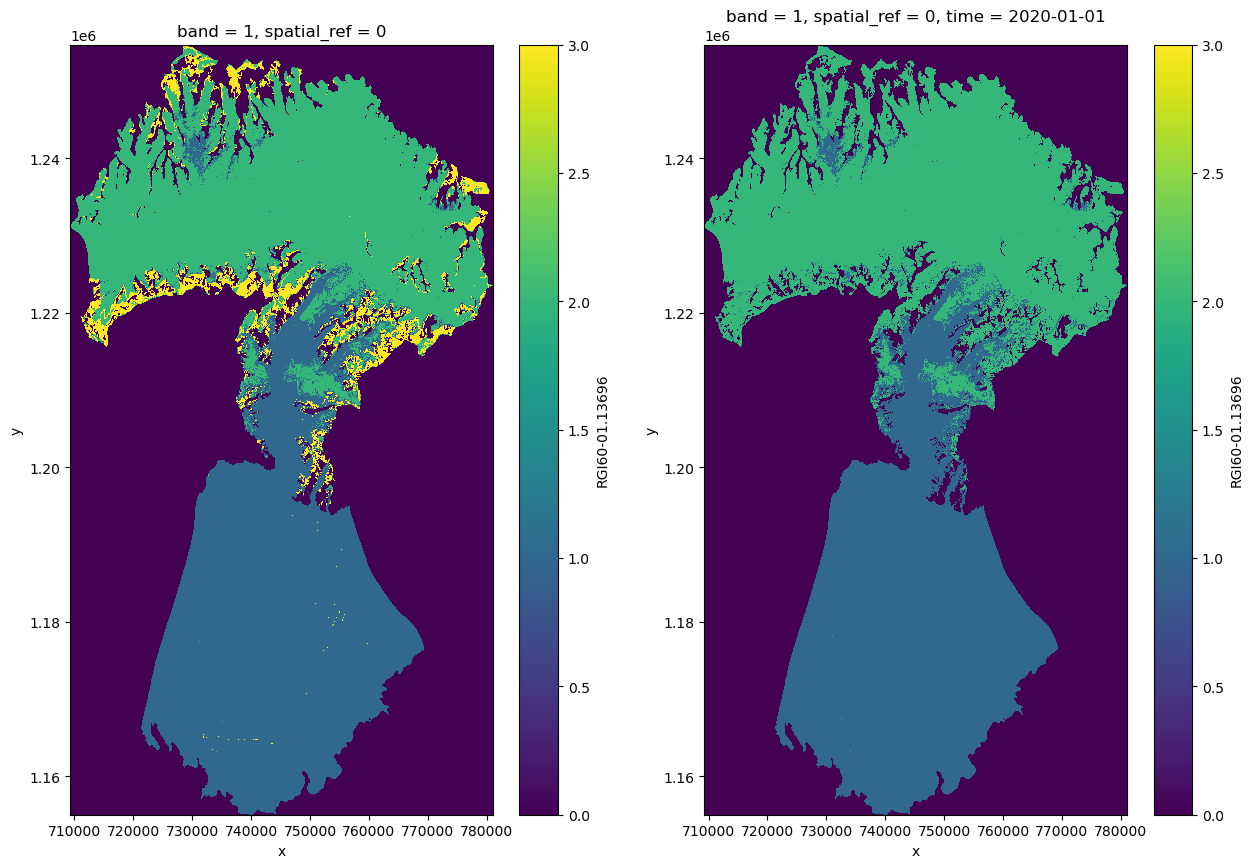

In [63]:
fig,axs = plt.subplots(1,2, figsize=(15,10))
snow.plot(ax=axs[0], vmin=0, vmax=3)
snow_infill.plot(ax=axs[1], vmin=0, vmax=3)

In [21]:
row_save

RGIId             RGI60-01.11971
ela                         1740
aar                       0.7507
off_glacier                    0
total_area                0.3711
total_observed            0.3301
total_snow                0.2478
Name: 516, dtype: object

In [56]:
snow_infill.squeeze()

<xarray.DataArray (y: 586, x: 789)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    band         int32 1
  * x            (x) float64 4.242e+05 4.242e+05 ... 4.321e+05 4.321e+05
  * y            (y) float64 1.509e+06 1.509e+06 ... 1.503e+06 1.503e+06
    spatial_ref  int32 0
    time         datetime64[ns] 2020-01-01
Attributes:
    AREA_OR_POINT:  Area
    description:    0: off glacier, no data. 1: ablation. 2: accumulation. 3:...
    long_name:      RGI60-01.00570
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0